In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
from tools import *

# Partie 1 : SIFT

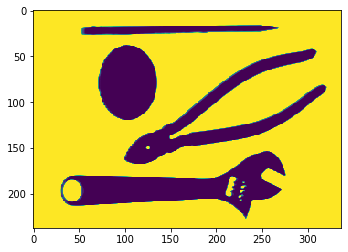

In [2]:
# example images
I = read_grayscale('data/tools.tiff')
I2 = read_grayscale('data/Scene/CALsuburb/image_0205.jpg')
plt.imshow(I)

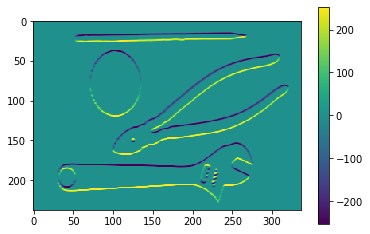

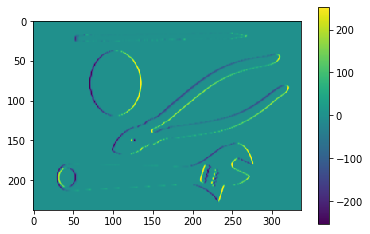

In [7]:
def compute_grad(I):
    ha,hb = np.array([-1,0,1]),np.array([1,2,1])
    Ix = conv_separable(I,hb,ha)/4
    Iy = conv_separable(I,ha,hb)/4
    return Ix, Iy

# example d'affichage du résultat
Ix, Iy = compute_grad(I)
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [8]:
def compute_grad_mod_ori(I):
    Ix,Iy = compute_grad(I)
    Gm = np.sqrt(Ix**2+Iy**2)
    Go = compute_grad_ori(Ix,Iy,Gm)
    return Gm, Go

In [9]:
def compute_sift_region(Gm, Go, mask=None):
    # mask 
    if mask is not None:
        Gm = Gm*mask
    sift = []
    for i in range(4):
        x = i*4
        for j in range(4):
            region = np.zeros(8)
            y = j*4
            for ii in range(4):
                xx = x+ii 
                for jj in range(4):
                    yy = y+jj
                    region[Go[xx,yy]] += Gm[xx,yy] 
            sift += region.tolist()
    sift = np.array(sift)
    
    # post processing
    norm = np.sqrt(np.sum(sift**2))
    if norm<0.5:
        sift = np.zeros(128)
        return sift
    else:
        sift = sift/norm
        sift[sift>0.2] = 0.2
        norm = np.sqrt(np.sum(sift**2))
        sift = sift/norm
    return sift

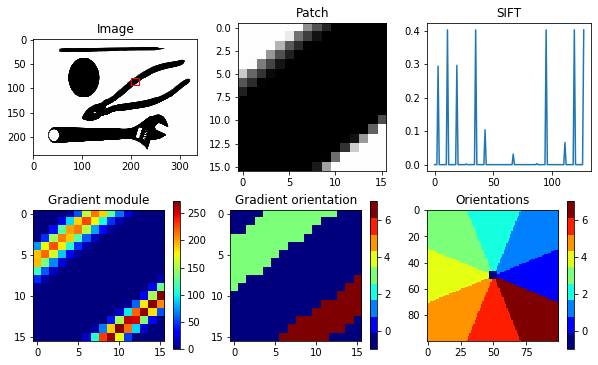

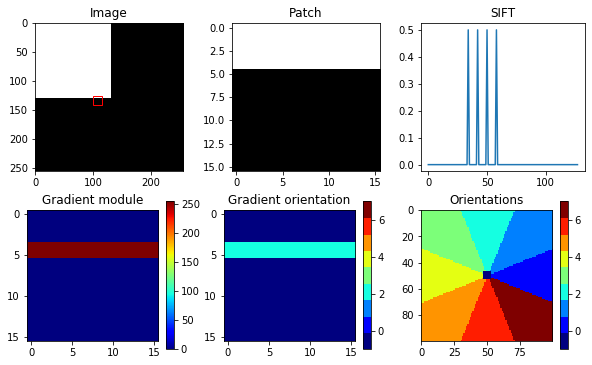

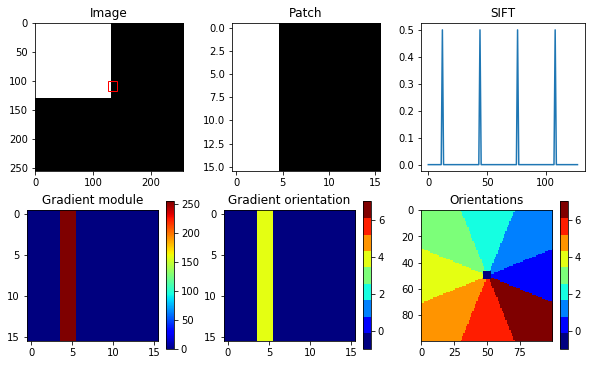

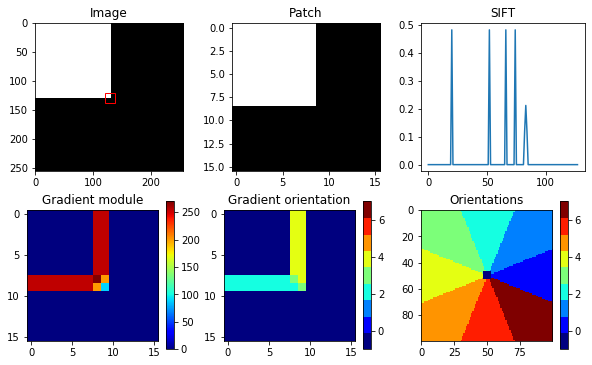

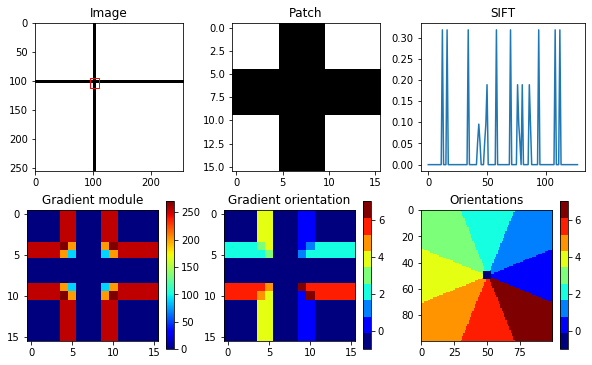

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3181317 , 0.        , 0.        ,
       0.        , 0.3181317 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.3181317 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05344409, 0.09560369, 0.05344409,
       0.        , 0.        , 0.        , 0.05344409, 0.09560369,
       0.18864812, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.3181317 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3181317 , 0.        , 0.        , 0.        , 0.     

In [10]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [7]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    # TODO calculs communs aux patchs
    sifts = np.zeros((len(x), len(y), 128))
    mask = gaussian_mask()
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            patch = im[xi:xi+16,yj:yj+16]
            Gm,Go = compute_grad_mod_ori(patch)
            sifts[i, j, :] = compute_sift_region(Gm,Go,mask=mask) 
    return sifts

# Partie 2 : Dictionnaire visuel

In [8]:
# Ideally, restart the Python kernel to start from a clean slate
import os
import numpy as np
from tools import *
from sift import *

In [9]:
# Paths config
dir_sc = os.path.join('data', 'Scene')
dir_sift = os.path.join('data', 'sift mine')
path_vdict = os.path.join('data', 'kmeans mine', 'vdict.npy')
path_vdsift = os.path.join('data', 'kmeans', 'vdsift.npy')
path_vdinames = os.path.join('data', 'kmeans', 'vdinames.npy')

inames, ilabls, cnames = load_dataset(dir_sc)

In [10]:
# If you want to look at the SIFTs that will be fed to compute_visual_dict:
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs


In [11]:
# Code here the `compute_visual_dict` function
import sklearn
from sklearn.cluster import KMeans
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]
    # TODO compute kmeans on `sift`, get cluster centers, add zeros vector
    kmeans = KMeans(n_clusters = n_clusters,random_state = 0).fit(sift)
    centers = kmeans.cluster_centers_
    centers = np.concatenate((np.array(centers),np.zeros((1,128))))
    return centers

In [12]:
# Run the visual dict computation (saved the first time)
vdict = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

Computing or loading visual dict


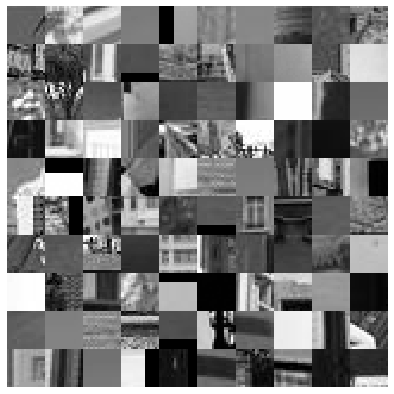

In [13]:
# Study of the dict
# Computing the regions and sifts
regions, sifts = get_regions_and_sifts(dir_sc, np.random.choice(inames, 30)) # Compute SIFT and regions from 30 random images#
#sifts = (sifts * 255).astype('uint8')
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

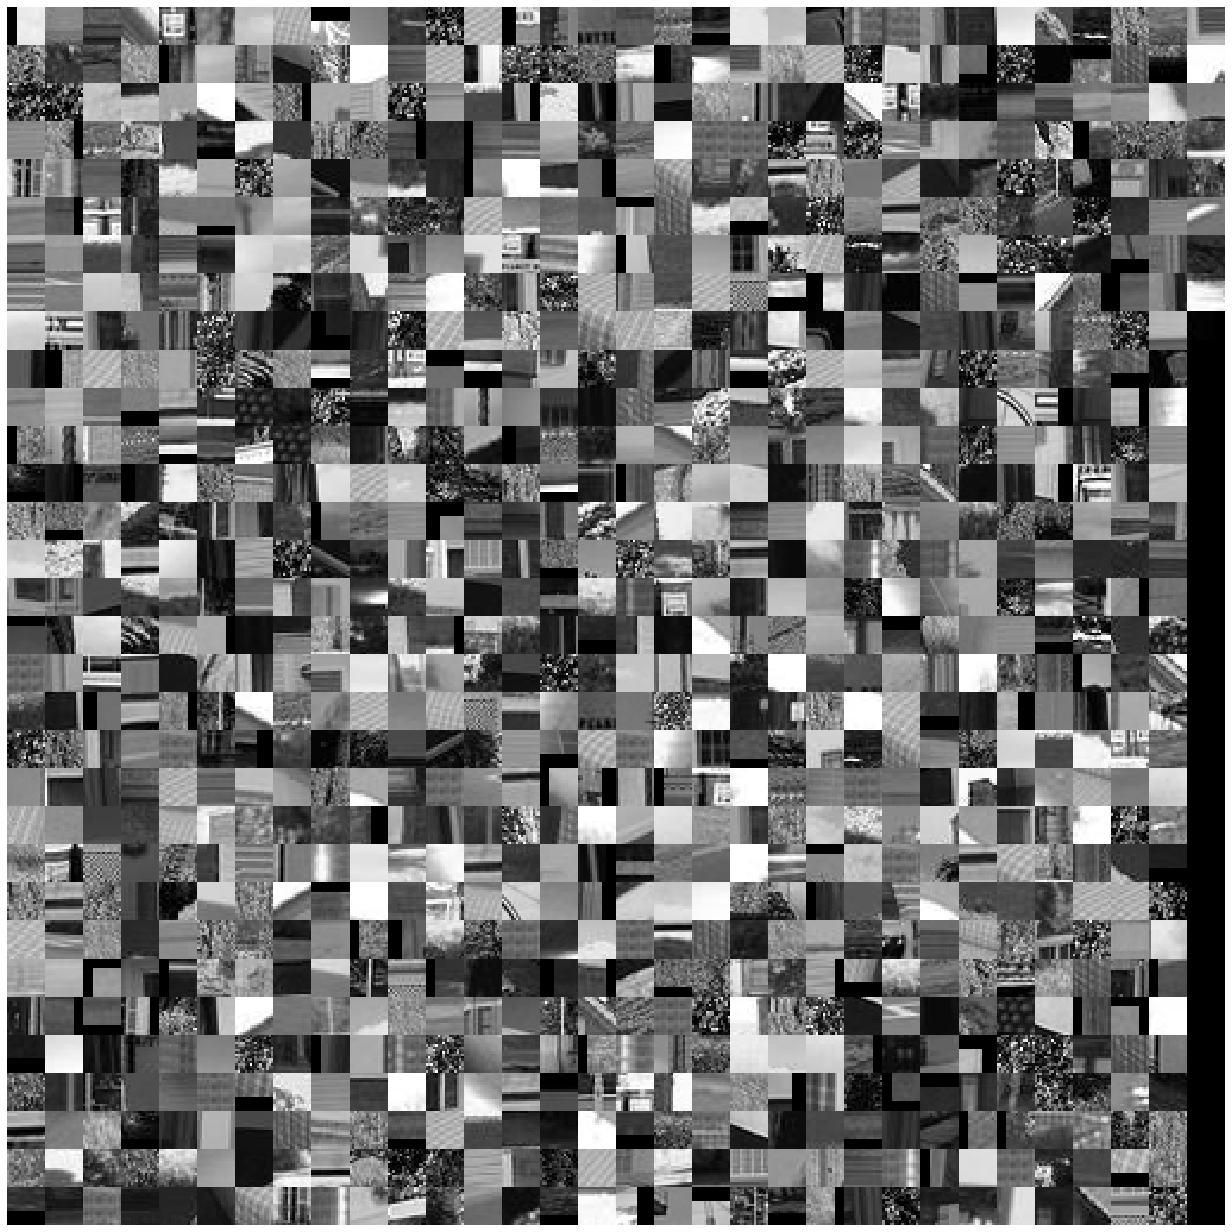

In [14]:
# TODO visually analyze the dict through similar example regions
# Ideally, create `vdregions`, a numpy array of size 1001 x 16 x 16 where each of the 1001 elements is a
# "prototype" patch that is very close to the cluster center
vdregions = []
for i in range(len(vdict)):
    center = vdict[i]
    distances = np.sqrt(np.sum((center - sifts)**2,axis=1))
    vdregions.append(regions[np.argsort(distances)[0]])
vdregions = np.array(vdregions)
display_images(vdregions)

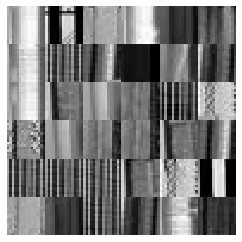

In [38]:
# n_closest regions to a random center
n_closest = 36

#choice
n_clusters = 1001
center = vdict[np.random.randint(0,n_clusters)]

#calculate n_closest
distances = np.sum((center - sifts)**2,axis=1)
indices = np.argsort(distances)[0:n_closest]

#save the n_closest patches
vdregions36 = []
for i in range(n_closest):
    vdregions36.append(regions[indices[i]])
vdregions36 = np.array(vdregions36)

#display
display_images(vdregions36)


# Partie 3 : BoW

In [39]:
# Compute BoW for an image
def compute_feats(vdict, image_sifts):
    # TODO compute BoW from `image_sifts`
    n_dict,ni_sifts,nj_sifts = len(vdict),len(image_sifts),len(image_sifts[0])
    z = np.zeros((n_dict))
    #hard coding + sum pooling
    for i in range(ni_sifts):
        for j in range(nj_sifts):
            distances = np.sum((vdict - image_sifts[i,j])**2,axis=1)
            indice = np.argmin(distances)
            z[indice] += 1
    #z /= np.sqrt(np.sum(z**2))
    z/= np.sum(z)
    return z

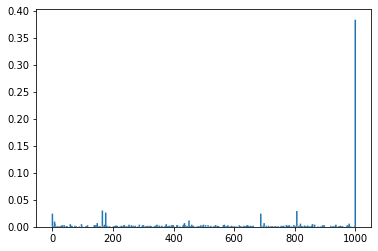

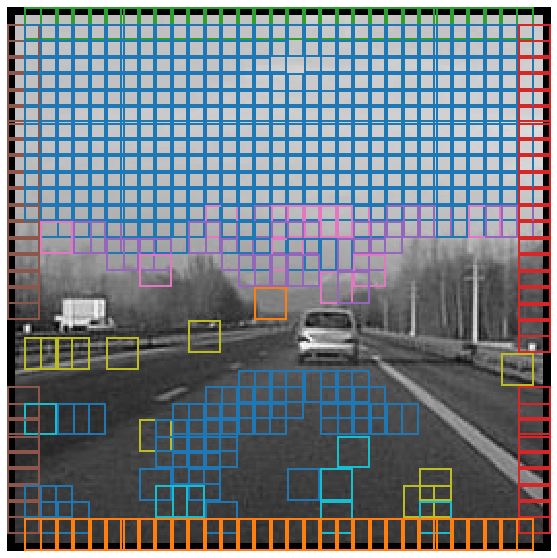

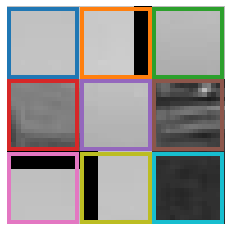

In [48]:
# Visualize your BoW on an image
iname = inames[1100]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
image_sifts = compute_sift_image(im)
image_sifts = (image_sifts * 255).astype('uint8')
regions = compute_regions(im)
feats = compute_feats(vdict, image_sifts)
im = auto_padding(im)
display_vdregions_image(im, vdict, image_sifts, feats, vdregions=None) # if you have vdregions, add it as input here